In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt
import math

In [65]:
size_functions = 128
not_sgd = True
if not_sgd:
  alpha = 0.05
  nb_epoch = 5000
else:
  alpha = 0.5
  nb_epoch = 7000

In [66]:
def generate_functions(size=128):
  df=[]
  for k in range(size+1):
    function_k = np.ones((size))
    for i in range(k):
      function_k[i] = 0
    df.append(function_k)
  return np.array(df)

In [67]:
def visualization_step_function(step_function):
  plt.plot(step_function)

def full_visualization(X, X_bis=np.empty(0), w=10):
  fig, axs = plt.subplots(math.ceil(X.shape[0]/w), w,figsize=(w*2,math.ceil(X.shape[0]/w)*2.2))
  for k in range (X.shape[0]):
    axs[k//w, k%w].plot(X[k])
    #axs[k//w, k%w].plot(X[k], marker='.', linestyle=None)
    if not X_bis.size == 0:
      axs[k//w, k%w].plot(X_bis[k])
      #axs[k//w, k%w].plot(X_bis[k], marker='.', linestyle=None)
    axs[k//w, k%w].set_title(str(k), y=0.99)


In [68]:
X_np = generate_functions(size_functions)
#np.random.shuffle(X_np)
X = torch.from_numpy(X_np).float()
print(X.shape)
print(X)
#visualization_step_function(X[64])
X_partial = torch.from_numpy(np.concatenate((X_np[:60],X_np[70:]))).float()
print(X_partial.shape)
print(X_partial)

torch.Size([129, 128])
tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [0., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 1.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
torch.Size([119, 128])
tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [0., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 1.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [69]:
#full_visualization(X_partial)

In [70]:

class Autoencoder(nn.Module):
    def __init__(self,size_functions):
        super(Autoencoder, self).__init__()
        self.fc1 = nn.Linear(size_functions,1) # encoder
        self.fc2 = nn.Linear(1,size_functions) # decoder
    def forward(self,X):
        A0 = X
        A1 = F.leaky_relu(self.fc1(X))  
        A2 = F.sigmoid(self.fc2(A1))
        return A2

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

class Encoder(nn.Module):
    def __init__(self,size_functions):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv1d(1,16,3,stride=2,padding=1)
        self.conv2 = nn.Conv1d(16,16,3,stride=2,padding=1)
        self.conv3 = nn.Conv1d(16,8,3,stride=2,padding=1)
        self.conv4 = nn.Conv1d(8,8,3,stride=2,padding=1)
        self.conv5 = nn.Conv1d(8,4,3,stride=2,padding=1)
        self.conv6 = nn.Conv1d(4,4,3,stride=2,padding=1)
        self.conv7 = nn.Conv1d(4,1,3,stride=2,padding=1)
    def forward(self,X):
        A0 = X
        A1 = F.leaky_relu(self.conv1(X))
        A2 = F.leaky_relu(self.conv2(A1))
        A3 = F.leaky_relu(self.conv3(A2))
        A4 = F.leaky_relu(self.conv4(A3))
        A5 = F.leaky_relu(self.conv5(A4))
        A6 = F.leaky_relu(self.conv6(A5))
        A7 = F.leaky_relu(self.conv7(A6))
        #assert A1.shape == ([129, 4, 64]),A1.shape
        return A7

class Decoder(nn.Module):
    def __init__(self,size_functions):
        super(Decoder, self).__init__()
        self.deconv1 = nn.ConvTranspose1d(1, 16,3,stride=2, output_padding = 1, padding = 1)
        self.deconv2 = nn.ConvTranspose1d(16, 16,3,stride=2, output_padding = 1, padding = 1)
        self.deconv3 = nn.ConvTranspose1d(16, 8,3,stride=2, output_padding = 1, padding = 1)
        self.deconv4 = nn.ConvTranspose1d(8, 8,3,stride=2, output_padding = 1, padding = 1)
        self.deconv5 = nn.ConvTranspose1d(8, 4,3,stride=2, output_padding = 1, padding = 1)
        self.deconv6 = nn.ConvTranspose1d(4, 4,3,stride=2, output_padding = 1, padding = 1)
        self.deconv7 = nn.ConvTranspose1d(4, 1,3,stride=2, output_padding = 1, padding = 1)
        """
        self.fc2 = nn.Linear(1,size_functions)"""
    def forward(self,X):
        A0 = X
        A1 = F.leaky_relu(self.deconv1(A0))
        A2 = F.leaky_relu(self.deconv2(A1))
        A3 = F.leaky_relu(self.deconv3(A2))
        A4 = F.leaky_relu(self.deconv4(A3))
        A5 = F.leaky_relu(self.deconv5(A4))
        A6 = F.leaky_relu(self.deconv6(A5))
        A7 = F.sigmoid(self.deconv7(A6))
        """
        B1 = F.sigmoid(self.fc2(A0))"""
        return A7

class Autoencoder_splitted(nn.Module):
    def __init__(self,size_functions):
        super(Autoencoder_splitted, self).__init__()
        self.encoder = Encoder(size_functions)
        self.decoder = Decoder(size_functions)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [71]:
model = Autoencoder_splitted(size_functions)

In [72]:
from torchsummary import summary

summary(model, (1, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 16, 64]              64
            Conv1d-2               [-1, 16, 32]             784
            Conv1d-3                [-1, 8, 16]             392
            Conv1d-4                 [-1, 8, 8]             200
            Conv1d-5                 [-1, 4, 4]             100
            Conv1d-6                 [-1, 4, 2]              52
            Conv1d-7                 [-1, 1, 1]              13
           Encoder-8                 [-1, 1, 1]               0
   ConvTranspose1d-9                [-1, 16, 2]              64
  ConvTranspose1d-10                [-1, 16, 4]             784
  ConvTranspose1d-11                 [-1, 8, 8]             392
  ConvTranspose1d-12                [-1, 8, 16]             200
  ConvTranspose1d-13                [-1, 4, 32]             100
  ConvTranspose1d-14                [-1

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [73]:
#criterion = nn.BCELoss()

criterion = nn.MSELoss()

if not_sgd:
  optimizer = torch.optim.Adam(model.parameters(), lr=alpha)
else:
  optimizer = torch.optim.SGD(model.parameters(), lr=alpha, weight_decay=1e-5)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch 0, loss 0.27152544260025024
epoch 1000, loss 0.0075806742534041405
epoch 2000, loss 0.008617532439529896
epoch 3000, loss 0.005211016163229942
epoch 4000, loss 0.0017965653678402305


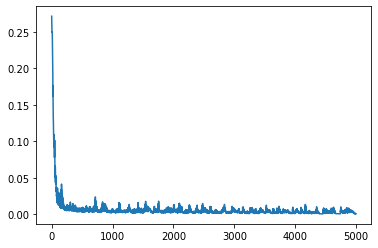

In [74]:
loss_l = []
for num_epoch in range(nb_epoch):
  X_predicted = model(X[:, None, :]) #Pass through autoencoder
  loss = criterion(X_predicted[:,0,:], X) # Compute loss 
  # Zero gradients, perform a backward pass, and update the weights. 
  optimizer.zero_grad() # re-init the gradients (otherwise they are cumulated)
  loss.backward() # perform back-propagation
  optimizer.step() # update the weights
  loss_l.append(loss.detach().numpy())
  if num_epoch % 1000 == 0:
      print('epoch {}, loss {}'.format(num_epoch, loss.item()))
plt.plot(loss_l)


In [75]:
model_partial = Autoencoder_splitted(size_functions)


if not_sgd:
  optimizer_partial = torch.optim.Adam(model_partial.parameters(), lr=alpha)
else:
  optimizer_partial = torch.optim.SGD(model_partial.parameters(), lr=alpha, weight_decay=1e-5)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Partial : epoch 0, loss 0.25670158863067627
Partial : epoch 1000, loss 0.0026844555977731943
Partial : epoch 2000, loss 0.005754949524998665
Partial : epoch 3000, loss 0.0019966592080891132
Partial : epoch 4000, loss 0.003241991624236107


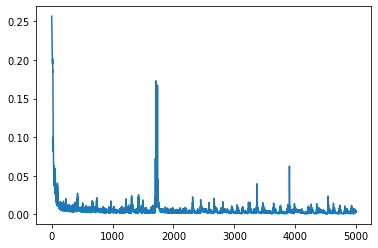

In [76]:
loss_partial = []
for num_epoch in range(nb_epoch):
  X_predicted_partial = model_partial(X_partial[:, None, :]) #Pass through autoencoder
  loss_2 = criterion(X_predicted_partial[:,0,:], X_partial) # Compute loss 
  # Zero gradients, perform a backward pass, and update the weights. 
  optimizer_partial.zero_grad() # re-init the gradients (otherwise they are cumulated)
  loss_2.backward() # perform back-propagation
  optimizer_partial.step() # update the weights
  loss_partial.append(loss_2.detach().numpy())
  if num_epoch % 1000 == 0:
      print('Partial : epoch {}, loss {}'.format(num_epoch, loss_2.item()))

plt.plot(loss_partial)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


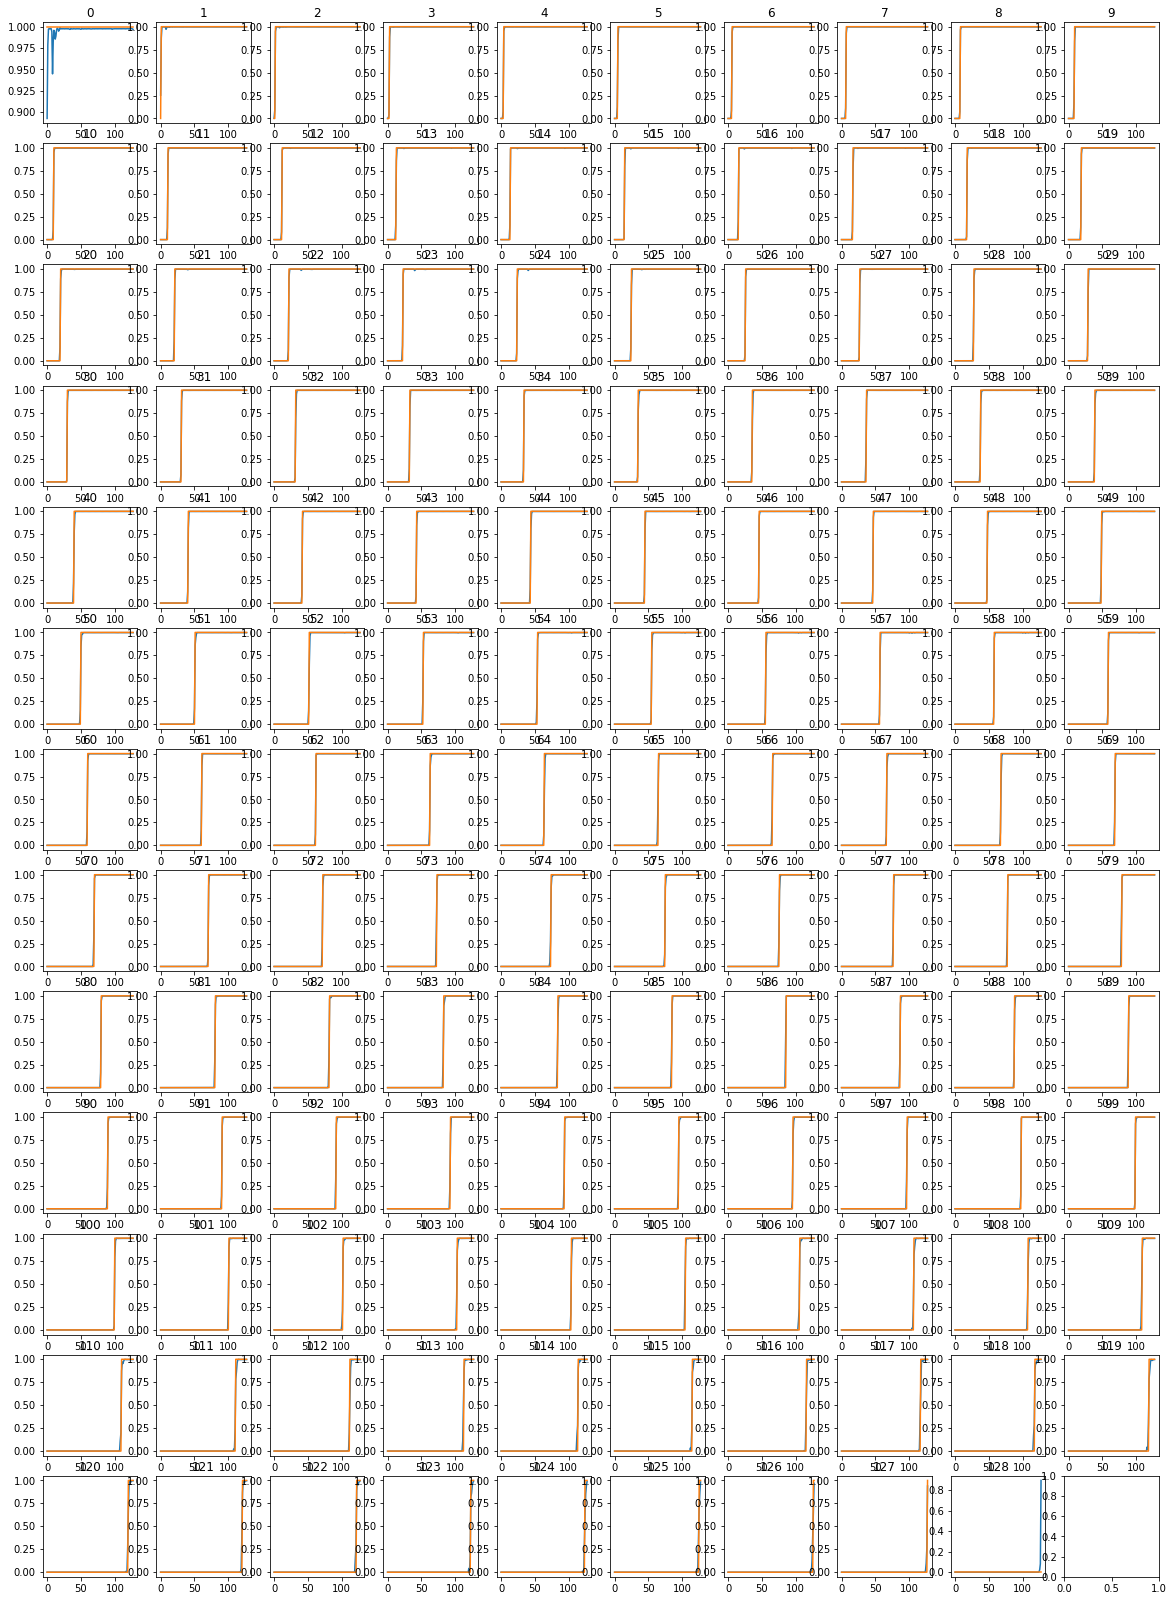

In [77]:
activation = {}

X_predicted = model(X[:, None, :]).detach().numpy()[:,0,:]
activation_full = model.encoder(X[:, None, :]).detach().numpy()[:,0,:]
#print(X_predicted.shape)
full_visualization(X_predicted,X)
#plt.plot(X_predicted[0])

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


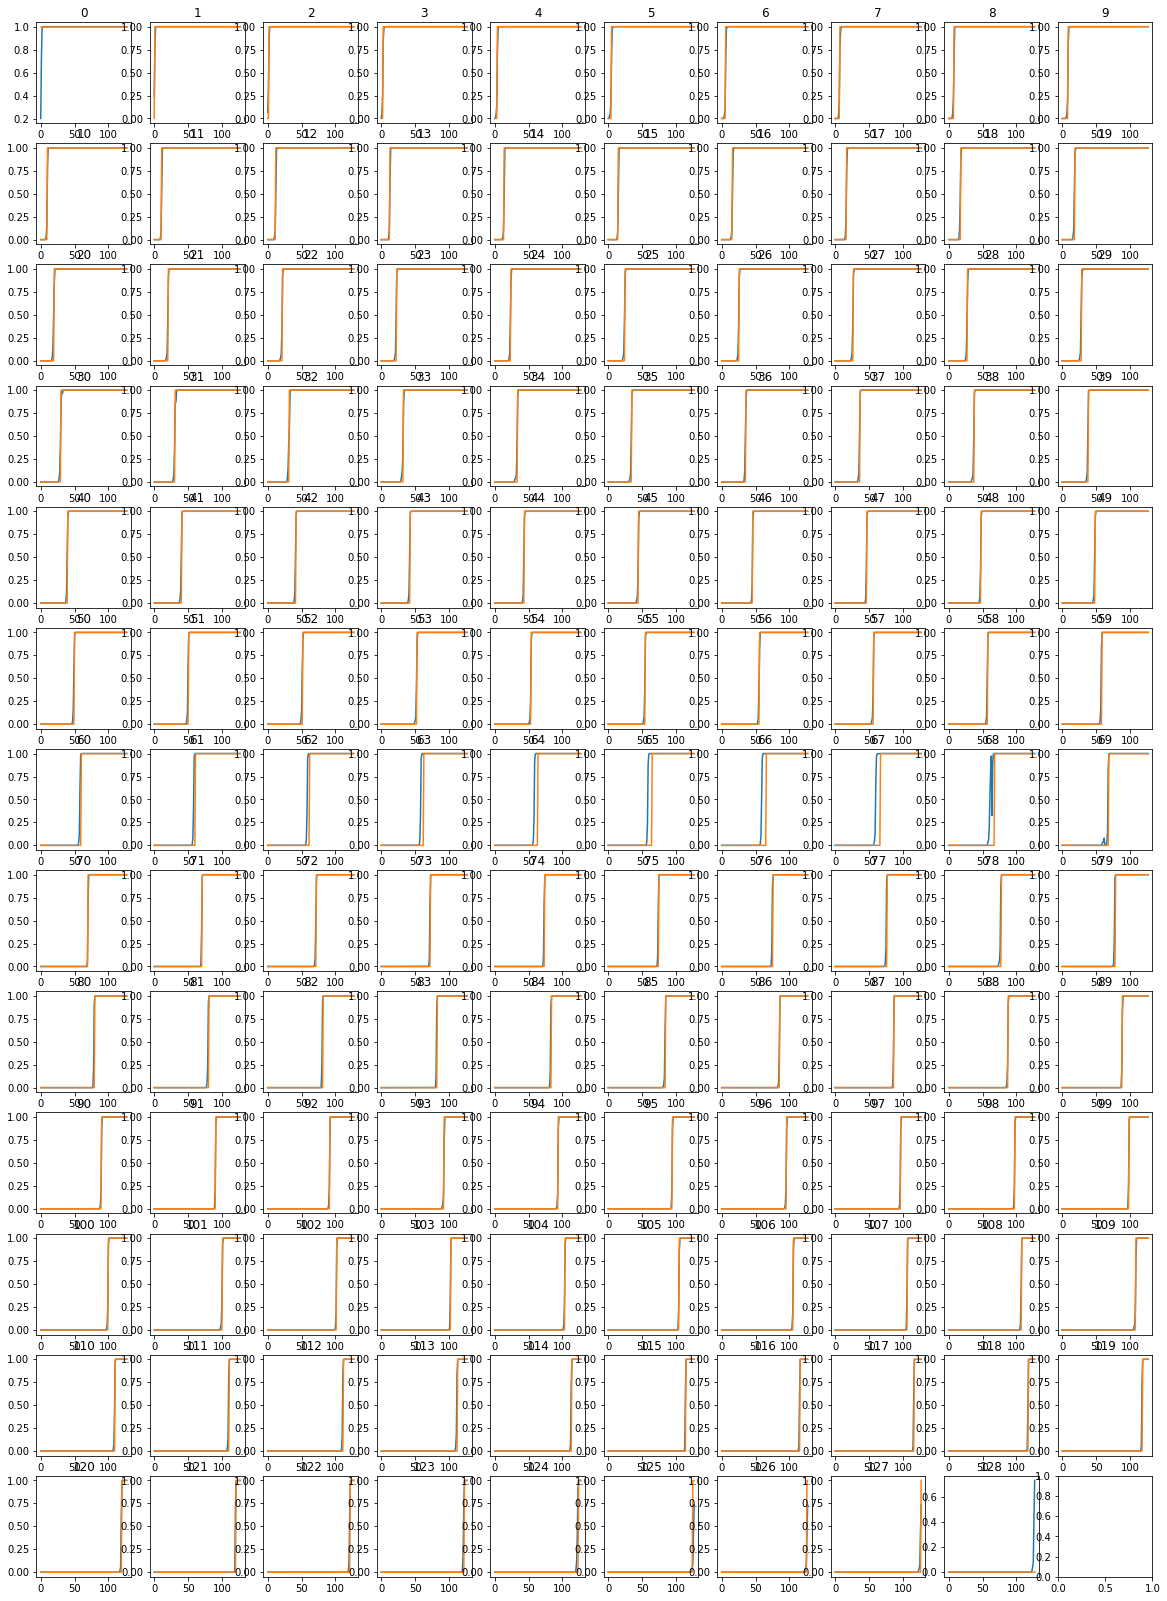

In [78]:
#Partial :
X_predicted_partial = model_partial(X[:, None, :]).detach().numpy()[:,0,:]
activation_partial = model_partial.encoder(X[:, None, :]).detach().numpy()[:,0,:]
#print(X_predicted_partial[0])

full_visualization(X_predicted_partial, X)

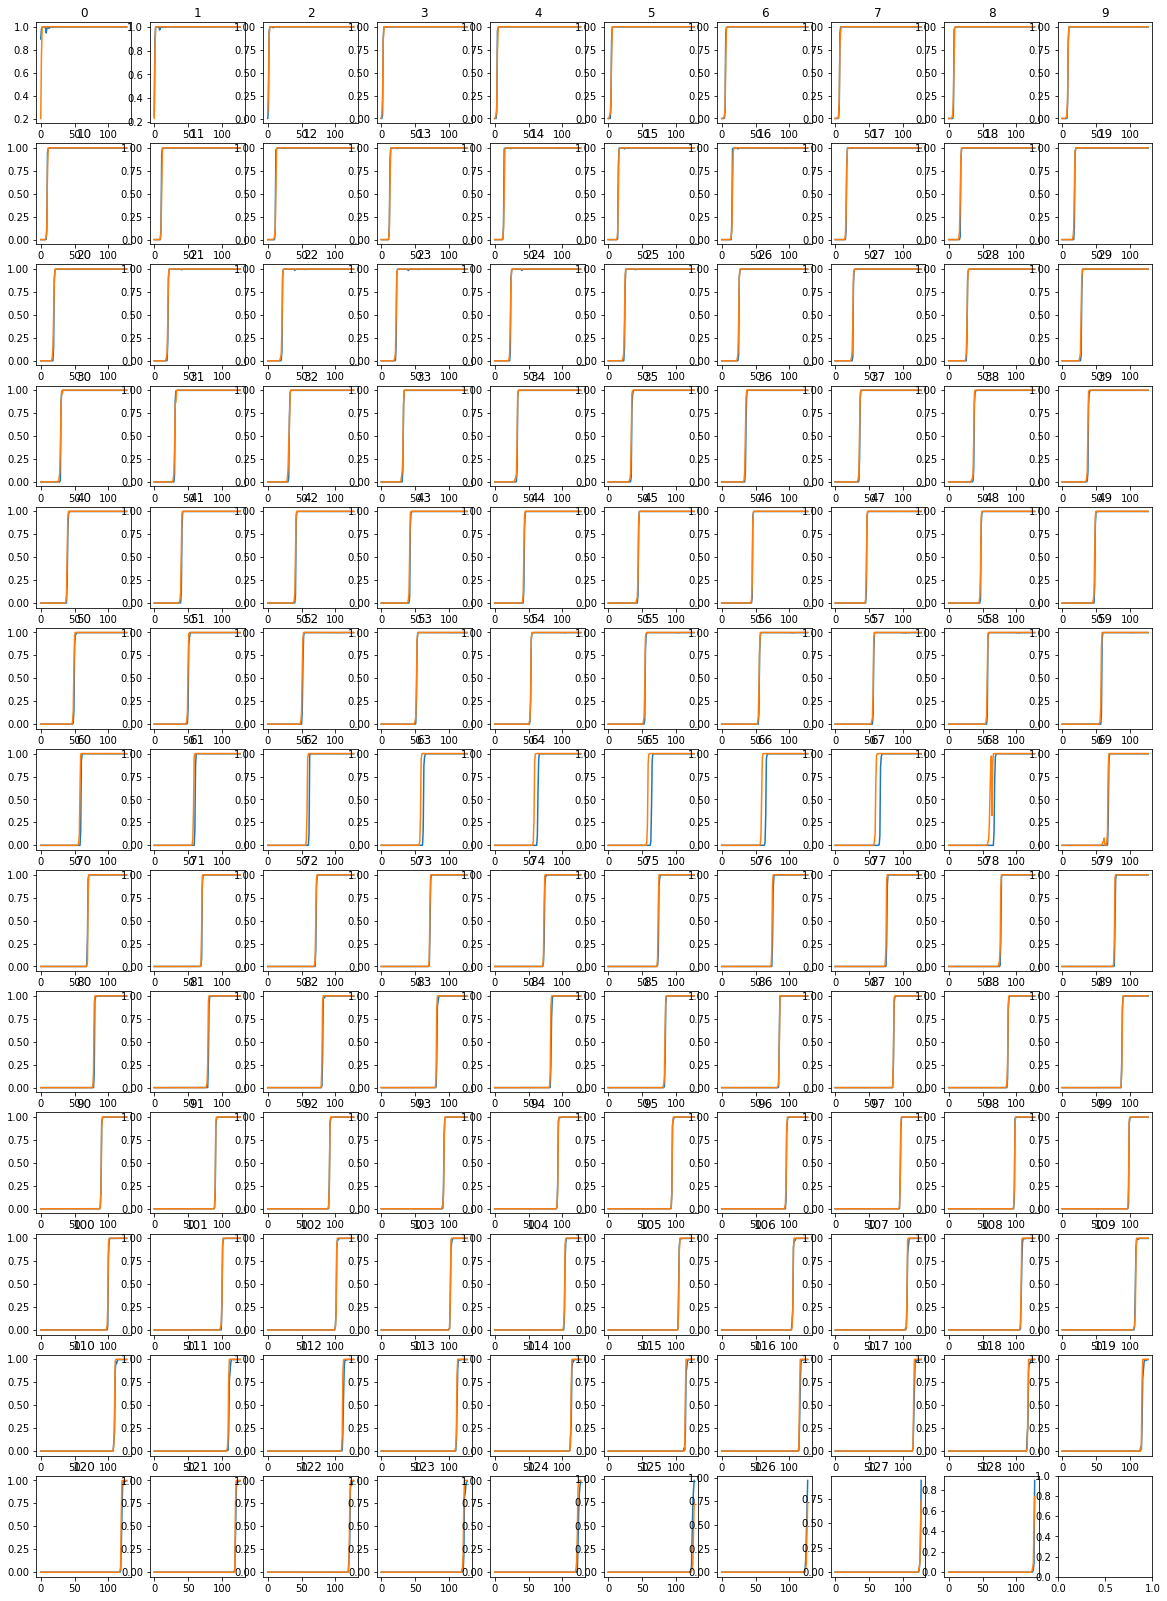

In [79]:
full_visualization(X_predicted, X_predicted_partial)

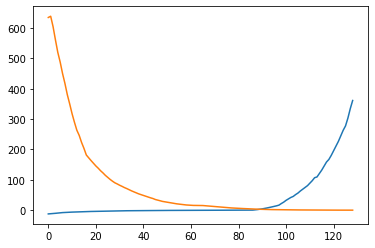

In [80]:
#print(activation['fc1'].detach().numpy())
#plt.plot(activation['fc1'].detach().numpy())

plt.plot(activation_full)
plt.plot(activation_partial)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


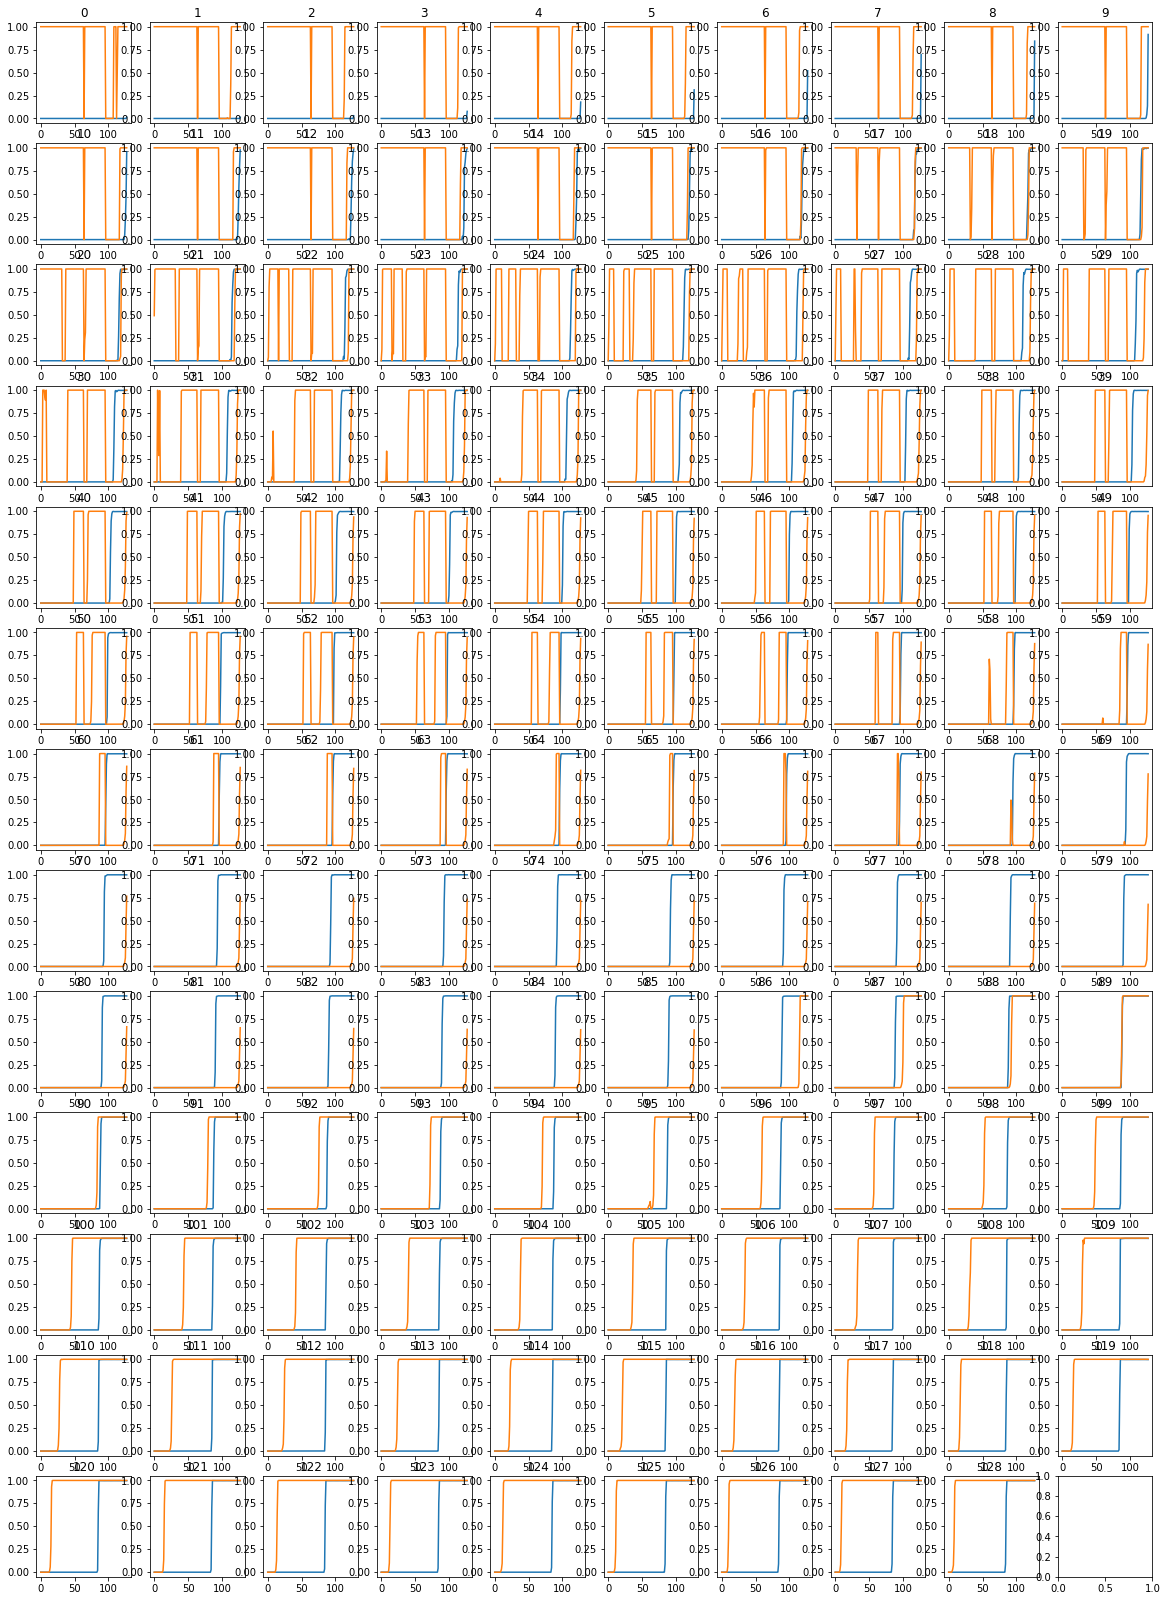

In [81]:
X_predicted_Epart_Dfull = model.decoder(torch.tensor(activation_partial[:, None, :])).detach().numpy()[:,0,:]
X_predicted_Efull_Dpart = model_partial.decoder(torch.tensor(activation_full[:, None, :])).detach().numpy()[:,0,:]
full_visualization(X_predicted_Epart_Dfull,X_predicted_Efull_Dpart)